In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats

In [4]:
df_daily = pd.read_excel('dataset_group4.xlsx', sheet_name='Kurs Transaksi USD', header=0)
df_monthly_inflasi = pd.read_excel('dataset_group4.xlsx', sheet_name='Inflasi', header=0)
df_monthly_BIRate = pd.read_excel('dataset_group4.xlsx', sheet_name='BI Rate', header=0)
df_monthly_cadanganDevisa = pd.read_excel('dataset_group4.xlsx', sheet_name='Cadangan Devisa', header=0)

df_daily['Tanggal'] = pd.to_datetime(df_daily['Tanggal'])

bulan_mapping = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March',
    'April': 'April', 'Mei': 'May', 'Juni': 'June',
    'Juli': 'July', 'Agustus': 'August', 'September': 'September',
    'Oktober': 'October', 'November': 'November', 'Desember': 'December'
}

df_monthly_inflasi['Period'] = df_monthly_inflasi['Period'].replace(bulan_mapping, regex=True)
df_monthly_inflasi['year_month'] = pd.to_datetime(df_monthly_inflasi['Period'], format='%B %Y').dt.to_period('M')

df_monthly_BIRate['Period'] = df_monthly_BIRate['Period'].replace(bulan_mapping, regex=True)
df_monthly_BIRate['year_month'] = pd.to_datetime(df_monthly_BIRate['Period'], format='%B %Y').dt.to_period('M')

df_monthly_cadanganDevisa['Period'] = df_monthly_cadanganDevisa['Period'].replace(bulan_mapping, regex=True)
df_monthly_cadanganDevisa['year_month'] = pd.to_datetime(df_monthly_cadanganDevisa['Period'], format='%B %Y').dt.to_period('M')

df_daily['year_month'] = df_daily['Tanggal'].dt.to_period('M')

In [5]:
df_monthly_neraca = pd.read_excel('dataset_group4.xlsx', sheet_name='Neraca', header=0)

df_monthly_neraca['Period'] = df_monthly_neraca['Period'].replace(bulan_mapping, regex=True)
df_monthly_neraca['year_month'] = pd.to_datetime(df_monthly_neraca['Period'], format='%B %Y').dt.to_period('M')

kolom_angka = ['Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas']

for kolom in kolom_angka:
    df_monthly_neraca[kolom] = df_monthly_neraca[kolom].astype(str)
    df_monthly_neraca[kolom] = df_monthly_neraca[kolom].str.replace('.', '', regex=True)
    df_monthly_neraca[kolom] = df_monthly_neraca[kolom].astype(float)


df = (
    df_daily
    .merge(df_monthly_inflasi[['year_month', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak']], on='year_month', how='left')
    .merge(df_monthly_BIRate[['year_month', 'BI Rate']], on='year_month', how='left')
    .merge(df_monthly_neraca[['year_month', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas']], on='year_month', how='left')
    .merge(df_monthly_cadanganDevisa[['year_month', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD']], on='year_month', how='left')
    .drop(columns='year_month')
)

df = df.drop(columns=['NO', 'Tanggal'])
df = df[::-1]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3186 entries, 3185 to 0
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Nilai                                      3186 non-null   int64  
 1   Kurs Jual                                  3186 non-null   float64
 2   Kurs Beli                                  3186 non-null   float64
 3   Umum                                       3186 non-null   float64
 4   Inti                                       3186 non-null   float64
 5   Harga Yang Diatur Pemerintah               3186 non-null   float64
 6   Barang Bergejolak                          3186 non-null   float64
 7   BI Rate                                    3186 non-null   float64
 8   Ekspor Migas                               3186 non-null   float64
 9   Ekspor Non Migas                           3186 non-null   float64
 10  Impor Migas             

In [6]:
print(df.head(5))

      Nilai  Kurs Jual  Kurs Beli  Umum  Inti  Harga Yang Diatur Pemerintah  \
3185      1     9171.0     9079.0  0.76  0.44                          0.43   
3184      1     9206.0     9114.0  0.76  0.44                          0.43   
3183      1     9226.0     9134.0  0.76  0.44                          0.43   
3182      1     9209.0     9117.0  0.76  0.44                          0.43   
3181      1     9206.0     9114.0  0.76  0.44                          0.43   

      Barang Bergejolak  BI Rate  Ekspor Migas  Ekspor Non Migas  ...  \
3185               2.02      6.0  3.142634e+09      1.242543e+10  ...   
3184               2.02      6.0  3.142634e+09      1.242543e+10  ...   
3183               2.02      6.0  3.142634e+09      1.242543e+10  ...   
3182               2.02      6.0  3.142634e+09      1.242543e+10  ...   
3181               2.02      6.0  3.142634e+09      1.242543e+10  ...   

      Impor Non Migas  Neraca Migas  Neraca Non Migas  \
3185     1.153503e+10   12304

In [7]:
print(df.columns)
df.drop(columns=['NO', 'Tanggal'], inplace=True, errors='ignore')
print(df.columns)
df.isnull().sum()

Index(['Nilai', 'Kurs Jual', 'Kurs Beli', 'Umum', 'Inti',
       'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate',
       'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas',
       'Neraca Migas', 'Neraca Non Migas',
       'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI',
       'Posisi Aktiva Luar Negeri Bersih',
       'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas',
       'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD'],
      dtype='object')
Index(['Nilai', 'Kurs Jual', 'Kurs Beli', 'Umum', 'Inti',
       'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate',
       'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas',
       'Neraca Migas', 'Neraca Non Migas',
       'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI',
       'Posisi Aktiva Luar Negeri Bersih',
       'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas',
       'Operasi Pasar Terbuka

Nilai                                        0
Kurs Jual                                    0
Kurs Beli                                    0
Umum                                         0
Inti                                         0
Harga Yang Diatur Pemerintah                 0
Barang Bergejolak                            0
BI Rate                                      0
Ekspor Migas                                 0
Ekspor Non Migas                             0
Impor Migas                                  0
Impor Non Migas                              0
Neraca Migas                                 0
Neraca Non Migas                             0
Uang Kertas dan Uang Logam yang Diedarkan    0
Saldo Giro Bank pada BI                      0
Posisi Aktiva Luar Negeri Bersih             0
Tagihan Bersih kepada Pemerintah Pusat       0
Kredit Likuiditas                            0
Operasi Pasar Terbuka                        0
Cadangan Devisa dalam juta USD               0
dtype: int64

In [8]:
df['Selisih_Kurs'] = df['Kurs Jual'] - df['Kurs Beli']  
df['Rasio_Kurs'] = df['Kurs Jual'] / df['Kurs Beli']  
df['Saldo_Neraca'] = df['Neraca Migas'] + df['Neraca Non Migas']
df.isnull().sum()

Nilai                                        0
Kurs Jual                                    0
Kurs Beli                                    0
Umum                                         0
Inti                                         0
Harga Yang Diatur Pemerintah                 0
Barang Bergejolak                            0
BI Rate                                      0
Ekspor Migas                                 0
Ekspor Non Migas                             0
Impor Migas                                  0
Impor Non Migas                              0
Neraca Migas                                 0
Neraca Non Migas                             0
Uang Kertas dan Uang Logam yang Diedarkan    0
Saldo Giro Bank pada BI                      0
Posisi Aktiva Luar Negeri Bersih             0
Tagihan Bersih kepada Pemerintah Pusat       0
Kredit Likuiditas                            0
Operasi Pasar Terbuka                        0
Cadangan Devisa dalam juta USD               0
Selisih_Kurs 

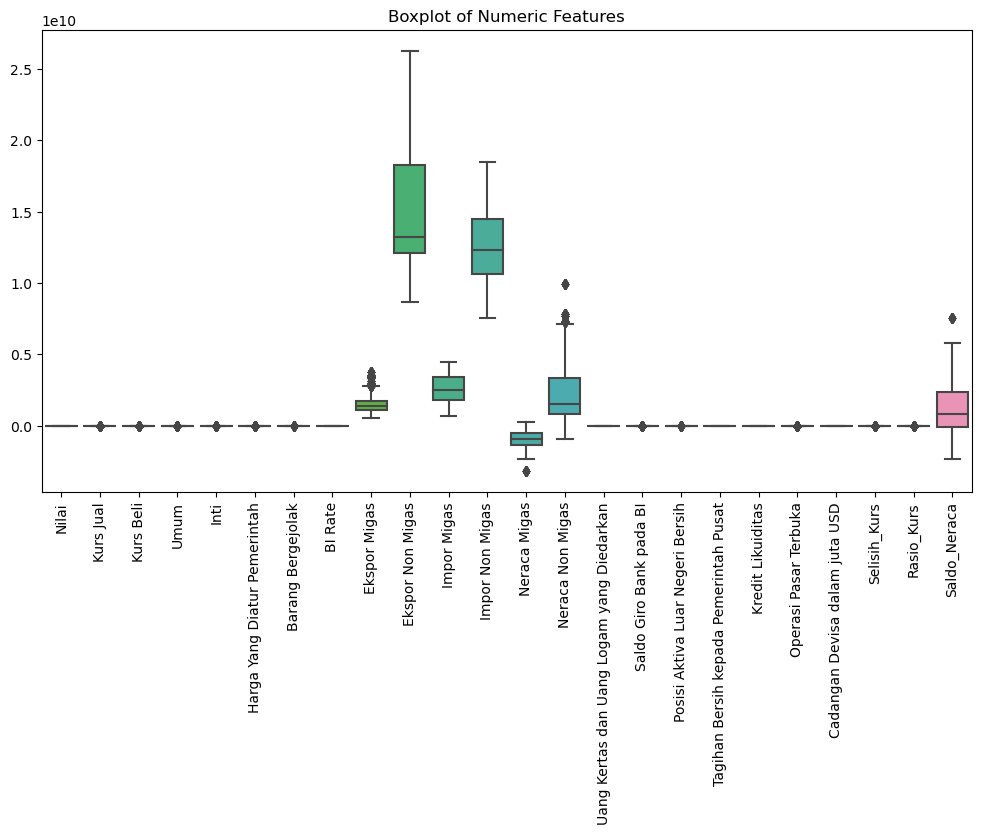

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.xticks(rotation=90)
plt.title("Boxplot of Numeric Features")
plt.show()

In [10]:
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
print(numerical_cols)

['Nilai', 'Kurs Jual', 'Kurs Beli', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD', 'Selisih_Kurs', 'Rasio_Kurs', 'Saldo_Neraca']


In [11]:
target_column = 'Kurs Jual'
numerical_cols = [col for col in numerical_cols if col != target_column]

print(numerical_cols)

['Nilai', 'Kurs Beli', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Kredit Likuiditas', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD', 'Selisih_Kurs', 'Rasio_Kurs', 'Saldo_Neraca']


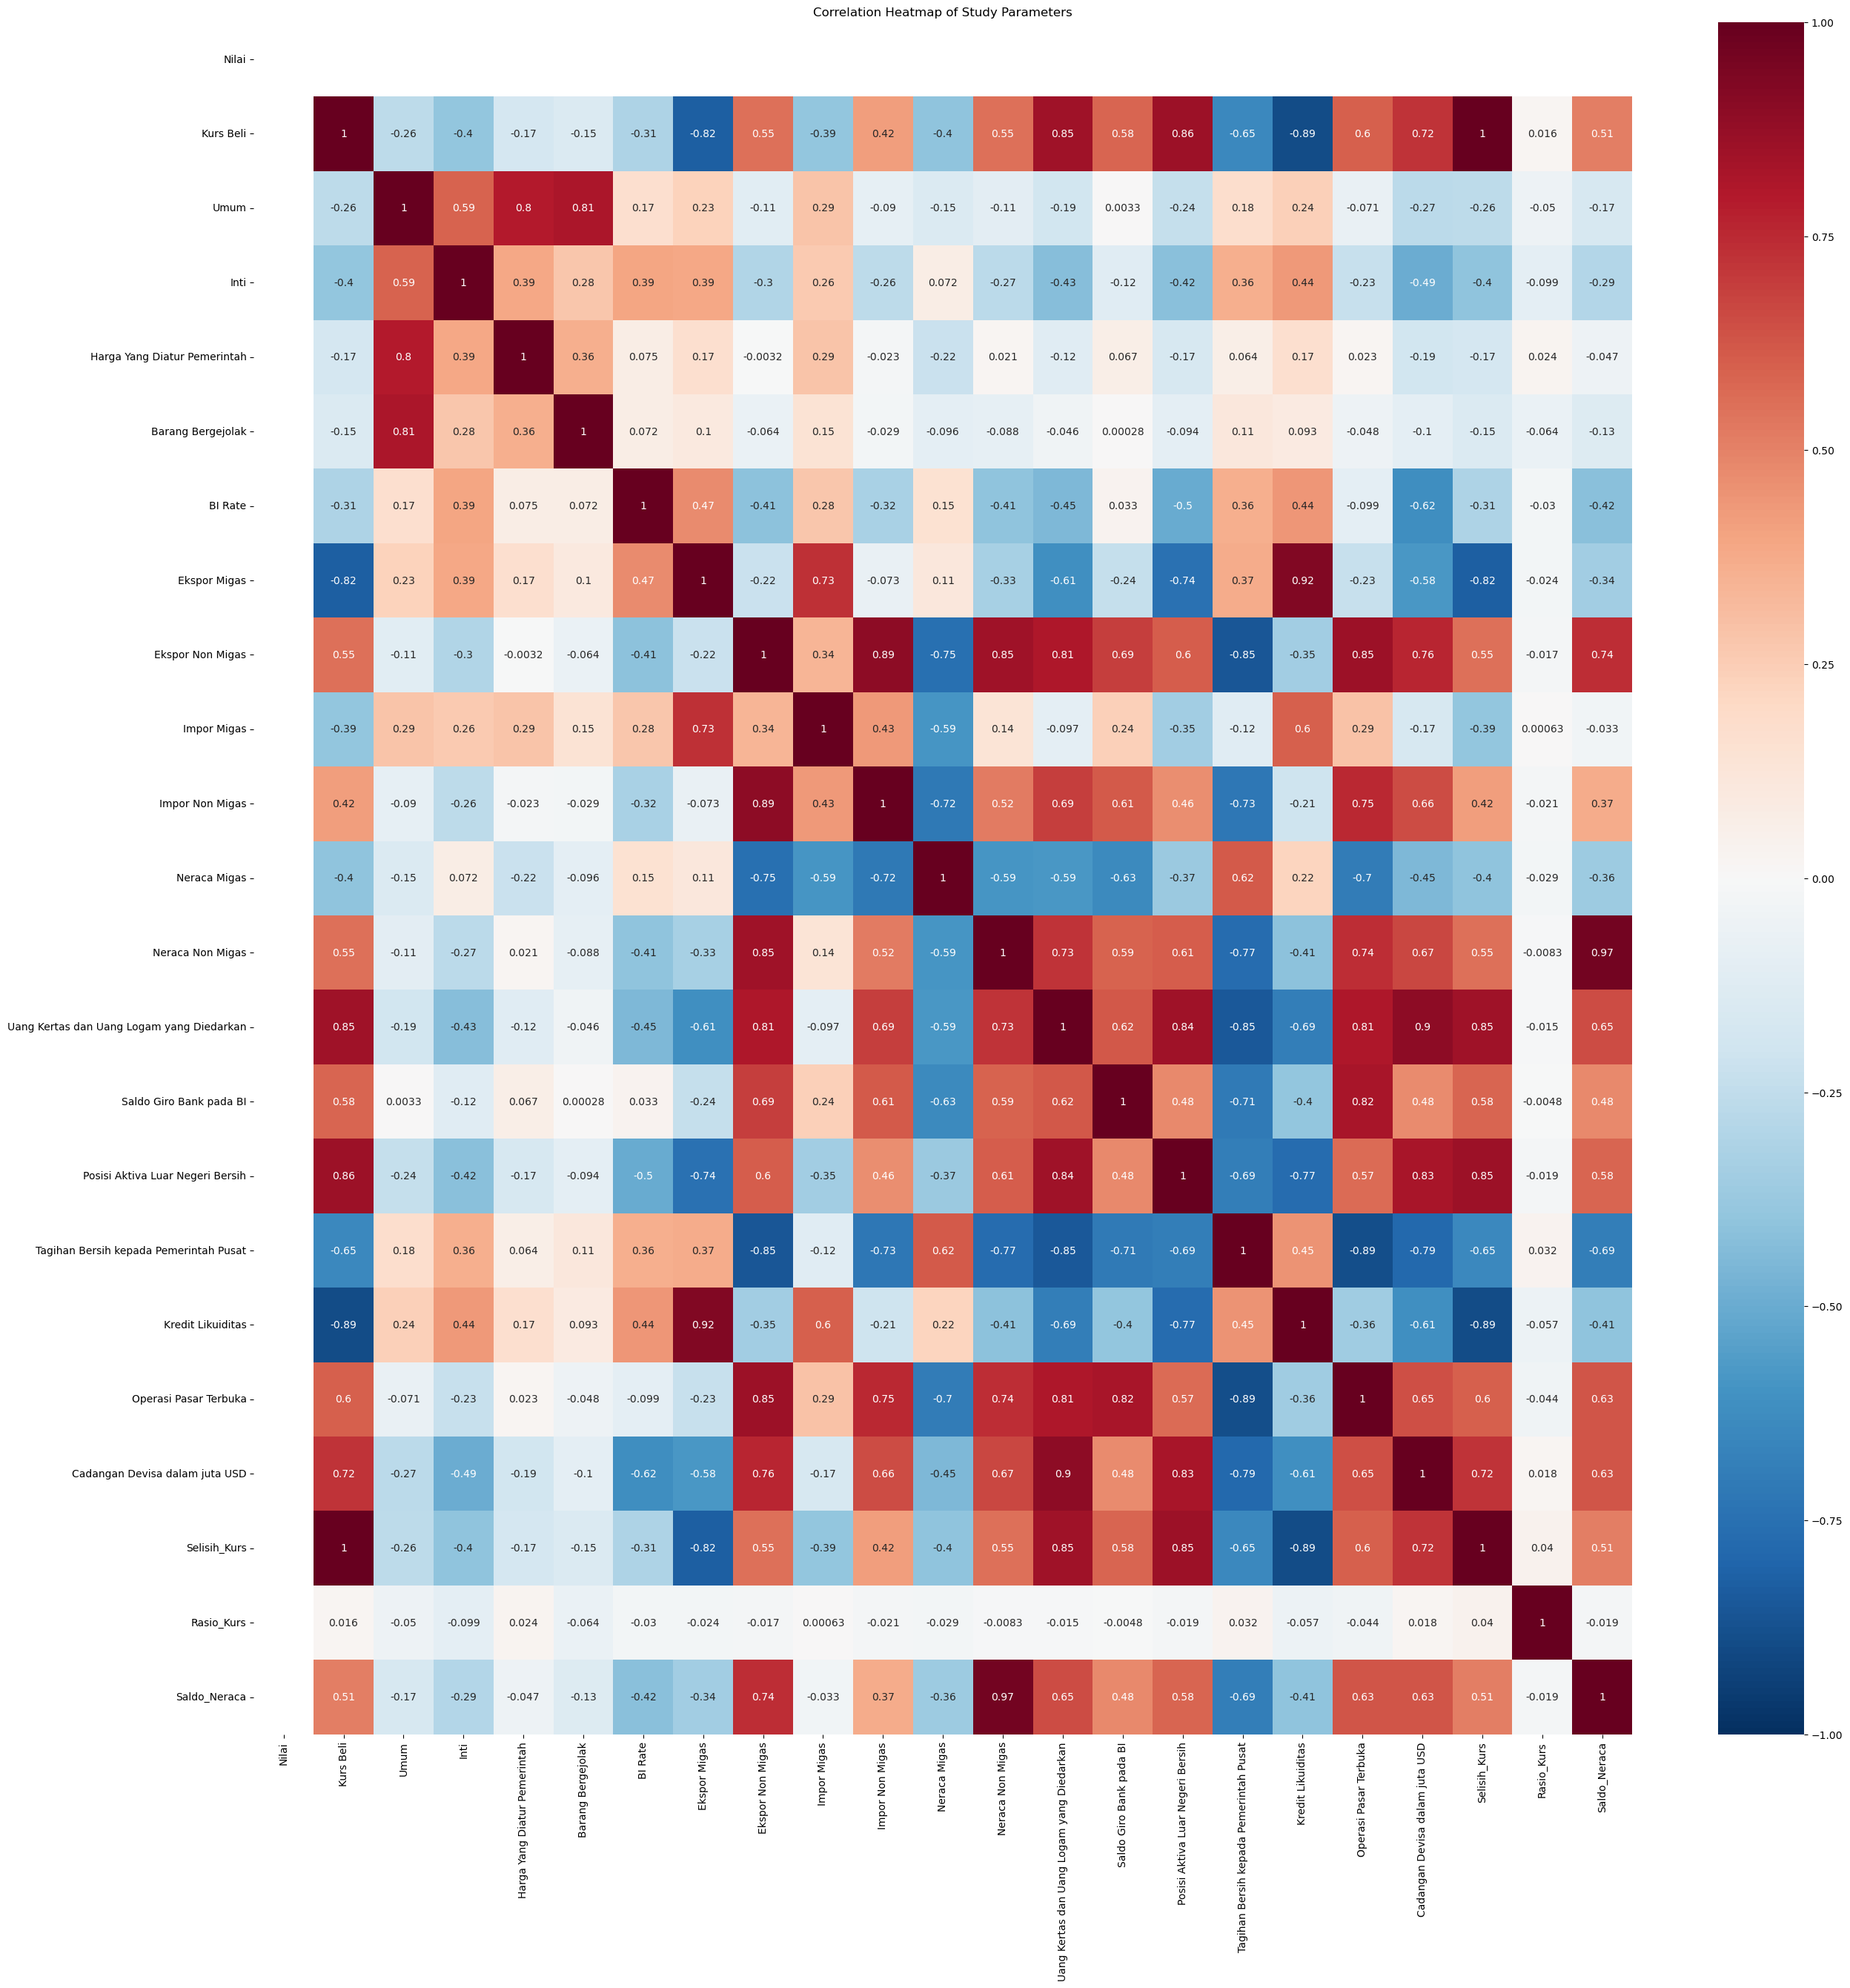

In [12]:
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Study Parameters')
plt.show()

In [13]:
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Highly correlated features (>0.9):", highly_correlated_features)

df = df.drop(columns=highly_correlated_features)

Highly correlated features (>0.9): {'Saldo_Neraca', 'Kredit Likuiditas', 'Selisih_Kurs'}


In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

print(vif_data)

                                      feature           VIF
0                                       Nilai  0.000000e+00
1                                   Kurs Jual  1.601169e+07
2                                   Kurs Beli  4.114292e+06
3                                        Umum  3.585746e+02
4                                        Inti  2.168812e+01
5                Harga Yang Diatur Pemerintah  9.176361e+01
6                           Barang Bergejolak  1.179236e+02
7                                     BI Rate  4.577025e+00
8                                Ekspor Migas           inf
9                            Ekspor Non Migas           inf
10                                Impor Migas           inf
11                            Impor Non Migas           inf
12                               Neraca Migas           inf
13                           Neraca Non Migas           inf
14  Uang Kertas dan Uang Logam yang Diedarkan  2.882975e+01
15                    Saldo Giro Bank pa

c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
c:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [15]:
y = df['Kurs Jual']
df = df.drop(columns=['Kurs Jual', 'Nilai'])

In [16]:
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

In [17]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

In [18]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [20]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
     ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [22]:
print(x_train.columns.tolist())

['Kurs Beli', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah', 'Barang Bergejolak', 'BI Rate', 'Ekspor Migas', 'Ekspor Non Migas', 'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas', 'Uang Kertas dan Uang Logam yang Diedarkan', 'Saldo Giro Bank pada BI', 'Posisi Aktiva Luar Negeri Bersih', 'Tagihan Bersih kepada Pemerintah Pusat', 'Operasi Pasar Terbuka', 'Cadangan Devisa dalam juta USD', 'Rasio_Kurs']


In [23]:
model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['Kurs Beli', 'Umum', 'Inti', 'Harga Yang Diatur Pemerintah',
       'Barang Bergejolak', 'BI Rate', 'Ekspor Migas', 'Ekspor Non Migas',
       'Impor Migas', 'Impor Non Migas', 'Neraca Migas', 'Neraca Non Migas',
       'Uang Kertas dan Uang Logam yang D...
       'Posisi Aktiva Luar Negeri Bersih',
       'Tagihan Bersih kepada Pemerintah Pusat', 'Operasi Pasar Terbuka',
       'Cadangan Devisa dalam juta USD', 'Rasio_Kurs'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('pca', PCA(n_components=0.95)),
                ('regressor', LinearRegression())])

In [24]:
y_pred = model.predict(x_test)

In [25]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("MAE  :", mae)
print("R²   :", r2)

print("Train score:", model.score(x_train, y_train))
print("Test score:", model.score(x_test, y_test))

RMSE : 477.4216777319253
MAE  : 376.2937954817558
R²   : 0.9403789906079123
Train score: 0.9311963833849651
Test score: 0.9403789906079123


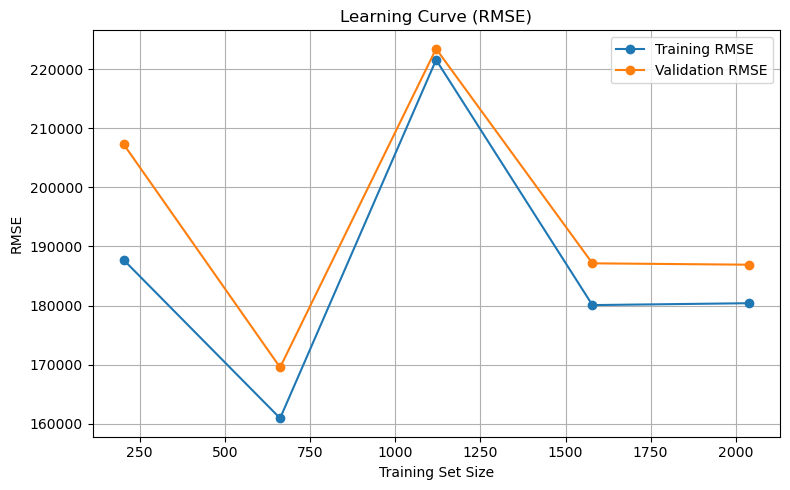

In [26]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

train_sizes, train_scores, val_scores = learning_curve(
    model, x_train, y_train,
    cv=5,
    scoring=rmse_scorer,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_rmse_mean = -np.mean(train_scores, axis=1)
val_rmse_mean = -np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse_mean, 'o-', label="Training RMSE")
plt.plot(train_sizes, val_rmse_mean, 'o-', label="Validation RMSE")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
cv_scores = cross_val_score(model, x_train, y_train, cv=5).mean()
print("Cross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean()*100:.2f}%")

Cross-validation scores: 0.9434904118626111
Mean CV score: 94.35%


In [28]:
final_model = model.fit(x_train, y_train)

In [29]:
test_score = final_model.score(x_test, y_test)
(print(f"Final test acc: {test_score*100:.2f}%"))

Final test acc: 94.04%


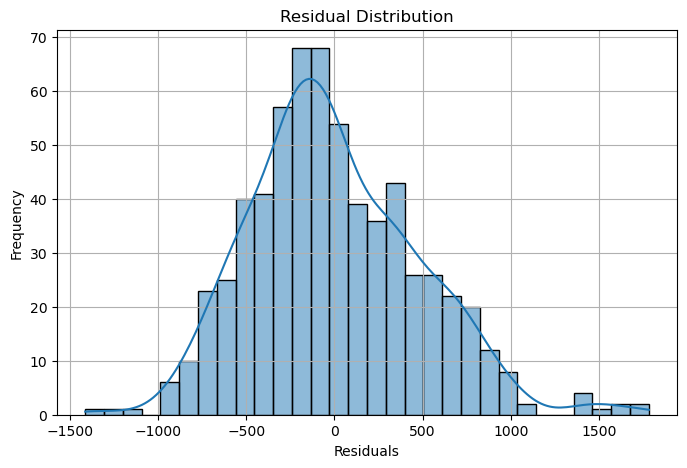

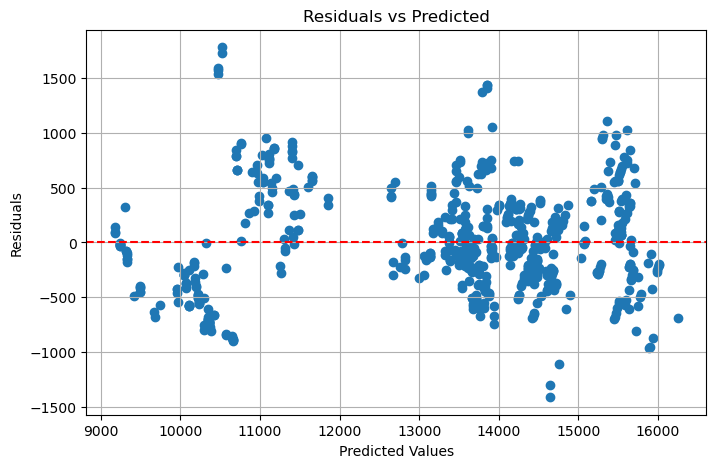

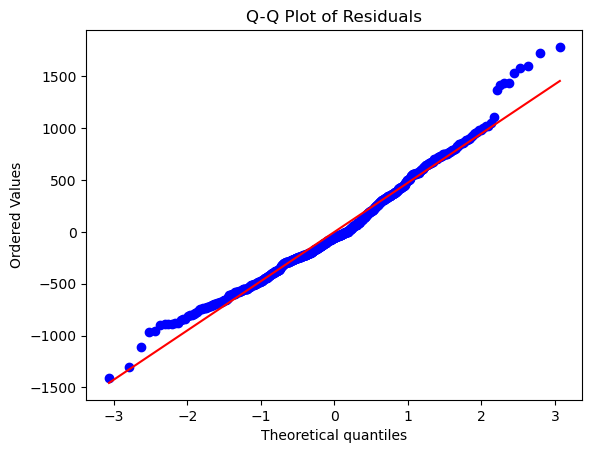

In [30]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


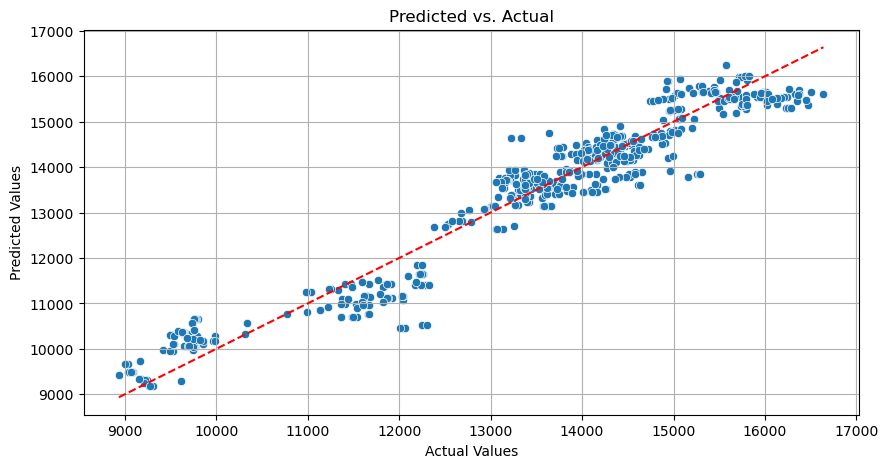

In [31]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual")
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE dengan scikit‑learn:", mse)

MSE dengan scikit‑learn: 227931.45836836632
